In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from keras.models import Sequential
from keras.layers import Dense, Activation,  BatchNormalization, Dropout
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from keras.models import load_model

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# Download NLTK resources if you haven't already
nltk.download('punkt')
nltk.download('stopwords')


 



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vferr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vferr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
##! pip install --upgrade pydantic


In [3]:
data = pd.read_csv('preprocess_data.csv')

C:\Users\vferr\AppData\Local\Temp\ipykernel_15140\4224766566.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('preprocess_data.csv')


In [4]:
data['br'] = data['br'].str.replace(".0", "")

In [5]:
data['br'].unique()

array(['101', '116', '163', '376', '262', '381', '465', '392', '316',
       '50', '365', '290', '386', '40', '324', '364', '407', '210', '412',
       '428', '280', '470', '20', '480', '158', '153', '222', '277',
       '282', '251', '70', '459', '259', '493', '230', '110', '343',
       '242', '285', '60', '319', '174', '232', '467', '405', '476', '10',
       '410', '423', '155', '287', '393', '421', '452', '356', '472',
       '414', '135', '435', '373', '432', '226', '369', '354', '267',
       'Unknown', '408', '359', '471', '349', '304', '424', '463', '293',
       '80', '146', '235', '30', '104', '468', '448', '430', '406', '330',
       '415', '402', '361', '487', '272', '427', '367', '495', '122',
       '419', '429', '401', '420', '436', '308', '317', '156', '469',
       '418', '425', '416', '488', '447', '437', '434', '352', '342',
       '403', '433', '485', '422', '265', '482', '484', '475', '426',
       '477', '457', '120', '383', '498', '377', '451', '404', '473', '0'

In [6]:
## Garantir que minha coluna ANO está no formato de int
data.ano = data.ano.astype(int)

In [7]:
for column in data.columns:
    if data[column].dtype == 'O':
        data[column] = data[column].str.lower()
        data[column] = data[column].replace(
            '(null)', 'unknown').replace('0', 'unknown')
        data[column] = data[column].str.encode(
            'ISO-8859-1').str.decode('utf-8', 'ignore')
        data[column] = data[column].fillna('unknown')
    else:
        data[column] = data[column].fillna(-99999999)


In [8]:
data.br.unique()

array(['101', '116', '163', '376', '262', '381', '465', '392', '316',
       '50', '365', '290', '386', '40', '324', '364', '407', '210', '412',
       '428', '280', '470', '20', '480', '158', '153', '222', '277',
       '282', '251', '70', '459', '259', '493', '230', '110', '343',
       '242', '285', '60', '319', '174', '232', '467', '405', '476', '10',
       '410', '423', '155', '287', '393', '421', '452', '356', '472',
       '414', '135', '435', '373', '432', '226', '369', '354', '267',
       'unknown', '408', '359', '471', '349', '304', '424', '463', '293',
       '80', '146', '235', '30', '104', '468', '448', '430', '406', '330',
       '415', '402', '361', '487', '272', '427', '367', '495', '122',
       '419', '429', '401', '420', '436', '308', '317', '156', '469',
       '418', '425', '416', '488', '447', '437', '434', '352', '342',
       '403', '433', '485', '422', '265', '482', '484', '475', '426',
       '477', '457', '120', '383', '498', '377', '451', '404', '473',
   

In [9]:
#### Our approach will be based on the idea of choosing best features, grouping our data 
#### using those features so We can have the amount of accidents for each combination 
#### of features. 

### Since our task is a regression (to predict values, not classes) not a classification
### We are not gonna be worried about data balacing. 

### Now, we are gonna work on the following steps first:

# Feature Selection.
# Missing values.
# Data Transformation: Standardization and Hot Encodings. 

## Note that in our preprocessing notebook we've already dealed with missing data
## turning them into Unknown or (numerical speaking) into -999999999.


In [10]:
all_columns = [ 'dia_semana', 'horario',
        'uf', 'br', 'km', 'municipio', 'causa_acidente', 'tipo_acidente',
        'classificacao_acidente', 'fase_dia', 'sentido_via',
        'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
        'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
        'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
        'delegacia', 'uop', 'ano']

grouped_data = data.groupby(all_columns).size().reset_index(name='num_accidents')


In [11]:
X = grouped_data.drop('num_accidents', axis=1)

Y = grouped_data['num_accidents']

In [12]:
### We were gonna use Mutual Information to choose between the features, since We have categorical data
### and hot encoding our data now would use more memory than is desirable, but, after a few tries, 
### the features choices were not consistent, because of that I changed the feature selection algorithm 
### for Chi-square test.

for column in X.columns:
    X[column] = X[column].astype('category').cat.codes


In [19]:
model = LogisticRegression()
num_features_to_select = 5 
num_max_iterations = 10  


selected_features = []

for _ in range(num_max_iterations):
    selector = RFE(model, n_features_to_select=num_features_to_select)
    selector = selector.fit(X, Y)
    selected_features.extend(X.columns[selector.support_])

    X = X[X.columns[~selector.support_]]
    if len(selected_features) >= num_features_to_select:
        break

selected_features = selected_features[:num_features_to_select]

C:\Users\vferr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vferr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Selected Features:
['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano']


C:\Users\vferr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
selected_features = ['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano']


In [14]:
important_features = list(selected_features)

In [15]:
important_features


['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano']

In [16]:
### We've got  what we neeed!! Great! 
# Using:
# ['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano']
# to predict the number of car_accidents!


In [17]:
dataset = data.groupby(important_features).size().reset_index(name='num_accidents')

In [18]:
dataset['num_accidents'].mean()


73.97535081919037

In [19]:
### Let´s hot encode our categorical features and normalize our num_accidents

In [20]:
scaler = MinMaxScaler()
dataset['num_accidents_norm'] = scaler.fit_transform(dataset[['num_accidents']])

scaler = StandardScaler()

anos = dataset['ano'].values.reshape(-1, 1)
scaled_ano = scaler.fit_transform(anos)

dataset['ano'] = scaled_ano


In [21]:
dataset.columns

Index(['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano', 'num_accidents',
       'num_accidents_norm'],
      dtype='object')

In [22]:
important_features

['uf', 'tipo_acidente', 'fase_dia', 'regional', 'ano']

In [23]:
dataset_ = pd.get_dummies(dataset, columns=['uf', 'tipo_acidente', 'fase_dia', 'regional'], drop_first=True)


In [24]:
X = dataset_.drop(["num_accidents", "num_accidents_norm"], axis=1)
Y = dataset_['num_accidents_norm']


In [25]:
X.columns

Index(['ano', 'uf_al', 'uf_am', 'uf_ap', 'uf_ba', 'uf_ce', 'uf_df', 'uf_es',
       'uf_go', 'uf_ma', 'uf_mg', 'uf_ms', 'uf_mt', 'uf_pa', 'uf_pb', 'uf_pe',
       'uf_pi', 'uf_pr', 'uf_rj', 'uf_rn', 'uf_ro', 'uf_rr', 'uf_rs', 'uf_sc',
       'uf_se', 'uf_sp', 'uf_to', 'uf_unknown',
       'tipo_acidente_atropelamento de pedestre',
       'tipo_acidente_atropelamento de pessoa', 'tipo_acidente_capotamento',
       'tipo_acidente_coliso com bicicleta', 'tipo_acidente_coliso com objeto',
       'tipo_acidente_coliso com objeto em movimento',
       'tipo_acidente_coliso com objeto esttico',
       'tipo_acidente_coliso com objeto fixo',
       'tipo_acidente_coliso com objeto mvel', 'tipo_acidente_coliso frontal',
       'tipo_acidente_coliso lateral',
       'tipo_acidente_coliso lateral mesmo sentido',
       'tipo_acidente_coliso lateral sentido oposto',
       'tipo_acidente_coliso transversal', 'tipo_acidente_coliso traseira',
       'tipo_acidente_danos eventuais', 'tipo_acidente_de

In [26]:
for i in X.columns:
    if i != 'ano':
        X[i] = [0 if x == False else 1 for x in X[i]]



In [27]:
X

,ano,uf_al,uf_am,uf_ap,uf_ba,uf_ce,uf_df,uf_es,uf_go,uf_ma,...,regional_sprf-rn,regional_sprf-ro,regional_sprf-rr,regional_sprf-rs,regional_sprf-sc,regional_sprf-se,regional_sprf-sp,regional_sprf-to,regional_uniprf,regional_unknown
0,0.384003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.793519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.998278,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.663580,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-1.458822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27217,-1.663580,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27218,-0.639789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27219,-1.458822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27220,-1.458822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
X_train, X_test, y_train, y_teste = train_test_split(X, Y, random_state=32, test_size=0.3)

In [29]:
## We are gonna create a MLP neural Network using Sequential from keras. 
## I am also adding BatchNormalization - To imporve stability and performance.
## As also output dropout - to prevent overfitting.  

In [30]:
### Before We start our neural network, we must work with a few steps:

# 1 - Let's choose our sctivation function (We chose ReLu) so We can initalize our weights(he_normal).
# 2 - Remeber to add Batch  normalization and dropouts - our probability in droping out a neuron is of 0.2 (the best response), which means 20%.
# 3 - Let's choose our optimizer (ADAM) and loss-function - I chose mean_squared_error which makes a lot of sense for me, since We have a regression problem.



In [31]:
X_train.dtypes

ano                 float64
uf_al                 int64
uf_am                 int64
uf_ap                 int64
uf_ba                 int64
                     ...   
regional_sprf-se      int64
regional_sprf-sp      int64
regional_sprf-to      int64
regional_uniprf       int64
regional_unknown      int64
Length: 86, dtype: object

In [54]:
model = Sequential()

In [55]:
model.add(
    Dense(units=100, input_dim=X_train.shape[1], kernel_initializer='he_normal'))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Activation('relu'))
#model.add(Dropout(0.2))


In [56]:
model.add(Dense(units=50, kernel_initializer='he_normal'))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Activation('relu'))
#model.add(Dropout(0.2))


In [57]:
model.add(Dense(units=1, kernel_initializer='he_normal'))


In [58]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [59]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               8700      
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 batch_normalization_7 (Bat  (None, 50)                200       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 50)               

Epoch 1/10
477/477 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0104
Epoch 2/10
477/477 [==============================] - 0s 953us/step - loss: 0.0079 - val_loss: 0.0041
Epoch 3/10
477/477 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 4/10
477/477 [==============================] - 0s 925us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/10
477/477 [==============================] - 0s 944us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/10
477/477 [==============================] - 0s 937us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
477/477 [==============================] - 0s 942us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/10
477/477 [==============================] - 0s 946us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
477/477 [==============================] - 0s 927us/step - loss: 0.0011 - val_loss: 9.3897e-04
Epoch 10/10
477/477 [==============================] - 0s 921us/step - loss: 8.920

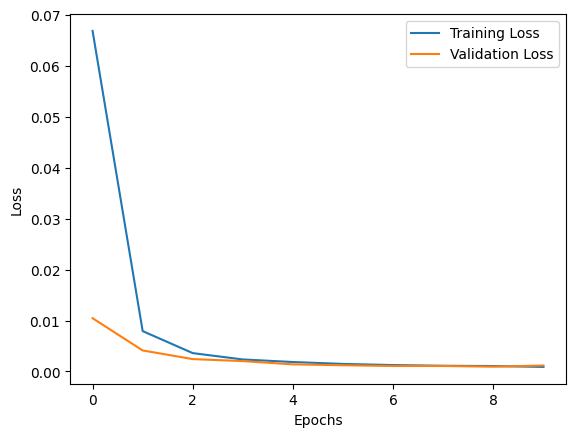

In [60]:
training = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=10, batch_size=32)

## Monitor:


loss = training.history['loss']
val_loss = training.history['val_loss']

# Plot training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [61]:
test_loss = model.evaluate(X_test, y_teste)
print(f'Test Loss: {test_loss}')


256/256 [==============================] - 0s 576us/step - loss: 0.0012
Test Loss: 0.0012494088150560856


In [62]:
y_pred = model.predict(X_test)


256/256 [==============================] - 0s 534us/step


In [63]:
mae = np.mean(np.abs(y_pred.flatten() - y_teste))
print(f'Mean Absolute Error (MAE): {mae}')

rmse = np.sqrt(np.mean((y_pred.flatten() - y_teste)**2))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 0.026892953241158188
Root Mean Squared Error (RMSE): 0.03534698430030013


In [64]:
model.save('mlp_model.h5')

C:\Users\vferr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
model = load_model('mlp_model.h5')

joblib.dump(model, 'mlp_model.pkl')


['mlp_model.pkl']

In [44]:
sample_columns = pd.DataFrame(columns = X_train.columns)

# for i in sample_columns.columns:
    #sample_columns[i] = 0

joblib.dump(sample_columns, 'colunas')


['colunas']

In [48]:
dataset['num_accidents'].max()


4681

In [47]:
dataset

,uf,tipo_acidente,fase_dia,regional,ano,num_accidents,num_accidents_norm
0,ac,atropelamento de animal,dawn,sprf-ac,0.384003,1,0.000000
1,ac,atropelamento de animal,dawn,sprf-ac,0.793519,1,0.000000
2,ac,atropelamento de animal,dawn,sprf-ac,0.998278,1,0.000000
3,ac,atropelamento de animal,dawn,unknown,-1.663580,3,0.000427
4,ac,atropelamento de animal,dawn,unknown,-1.458822,2,0.000214
...,...,...,...,...,...,...,...
27217,unknown,coliso transversal,full day,unknown,-1.663580,1,0.000000
27218,unknown,coliso traseira,full night,unknown,-0.639789,1,0.000000
27219,unknown,queda de motocicleta / bicicleta / veculo,full night,unknown,-1.458822,1,0.000000
27220,unknown,sada de pista,dusk,unknown,-1.458822,1,0.000000


In [46]:
data.iloc[100][important_features]

uf                       pe
tipo_acidente    tombamento
fase_dia           full day
regional            sprf-pe
ano                    2023
Name: 100, dtype: object